# Hallucination des LLMs:
Bienvenue dans ce Travaux Pratiques (TP) où nous allons explorer le phénomène intrigant des hallucinations des LLMs. Les hallucinations, généralement associées à des conditions neurologiques ou psychiatriques, sont des perceptions qui n'ont pas de base dans la réalité. Cependant, dans le contexte des LLMs, ces perceptions prennent une toute nouvelle dimension.

Les LLMs sont des modèles d'apprentissage automatique qui sont entraînés sur d'énormes quantités de texte. Ils apprennent à prédire le texte suivant sur la base du texte précédent, ce qui leur permet de générer des phrases et des paragraphes qui semblent logiques et cohérents. Cependant, comme tout modèle d'apprentissage automatique, les LLMs peuvent parfois faire des erreurs, ou "halluciner", en générant du texte qui n'a pas de sens, qui est complètement déconnecté du contexte donné ou qui n'est pas factuel.

Dans ce TP, nous allons plonger dans le monde fascinant des LLMs et de leurs hallucinations. Nous allons explorer comment ces modèles fonctionnent, pourquoi ils hallucinent, et comment nous pouvons détecter.

Avant de nous plonger dans l'univers fascinant des LLMs, il y a quelques préparations à faire. Pour assurer le bon déroulement de ce TP, vous devrez d'abord télécharger:

In [1]:
!pip install langchain
!pip install langchain_community
!pip install nltk
!pip install llama-cpp-python
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.6/973.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.4/310.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 MB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━

Une fois que vous avez téléchargé les dépendances, vous pouvez ensuite les importer dans votre notebook:

In [2]:
from langchain.llms import LlamaCpp
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from llama_cpp import Llama
from math import *
import numpy as np

Enfin, pour étudier les hallucinations, nous utiliserons le modèle mistral-7B quantizé, que vous pouvez téléchargé avec la cellule ci-dessous:

In [3]:
!huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir . --local-dir-use-symlinks False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
mistral-7b-instruct-v0.2.Q4_K_M.gguf: 100% 4.37G/4.37G [00:28<00:00, 152MB/s]
Download complete. Moving file to mistral-7b-instruct-v0.2.Q4_K_M.gguf
mistral-7b-instruct-v0.2.Q4_K_M.gguf


Nous pouvons donc commencer !!

#I. Detection d'hallucination:

Maintenant que nous avons nos dépendances en place, il est temps de nous plonger dans le cœur du sujet : les hallucinations des LLMs. Mais qu'est-ce qu'une hallucination dans ce contexte ?

Une hallucination, dans le domaine des LLMs, se produit lorsque le modèle génère du texte qui n'a pas de sens ou qui est complètement déconnecté du contexte donné. C'est comme si le modèle "voyait" ou "imaginait" des choses qui ne sont pas réellement présentes dans les données.

Plusieurs facteurs peuvent contribuer à ces hallucinations :


1.   Biais du dataset : Si le jeu de données d'entraînement est biaisé d'une
certaine manière, le modèle apprendra ces biais et les reproduira dans ses prédictions. Par exemple, si le jeu de données contient principalement des exemples positifs, le modèle peut "halluciner" des résultats positifs même dans des situations où ils ne sont pas appropriés.

2.   Overfitting : Cela se produit lorsque le modèle est trop complexe par rapport à la quantité et à la variété des données d'entraînement disponibles. Dans ce cas, le modèle peut "apprendre par cœur" les données d'entraînement et avoir du mal à généraliser à de nouvelles situations, ce qui peut conduire à des hallucinations.

3. Non accès à l'information : Les LLMs ne disposent pas d'un accès direct à l'information du monde réel. Ils ne peuvent générer du texte qu'en se basant sur ce qu'ils ont appris lors de leur entraînement. Par conséquent, ils peuvent halluciner des informations qu'ils n'ont pas ou mal interpréter les informations qu'ils ont..

Pour notre étude, nous allons nous concentrer sur le dernier point : le manque d'accès à l'information par les LLMs. Dans la pratique, cela signifie que lorsque le modèle n'a pas accès à une information spécifique, il ne peut pas être sûr de ses prédictions.

Lorsqu'un LLM n'est pas sûr de la prédiction qu'il doit faire, la distribution de probabilité des prochains tokens qu'il prédit sera plus "plate".

Cela peut sembler un peu abstrait, mais ne vous inquiétez pas, tout deviendra clair lorsque nous commencerons à travailler avec les données. En étudiant les logprobs - les logarithmes des probabilités - des tokens générés par le modèle, nous pouvons mesurer la certitude du modèle. Plus la distribution de probabilité est "plate", moins le modèle est sûr de lui. Mettons en évidence cela:

In [4]:
def load_llm(model_path):

		# On charge le LLM sous format quantisé. Cf la descriptions des paramètres ci-dessous.
    llm = Llama(
        model_path=model_path, stop=["Question"], max_tokens=200, temperature=0.2,
				n_ctx=8000, n_batch=1024, n_gpu_layers=-1, logits_all=True
    )

    return llm

llm = load_llm("mistral-7b-instruct-v0.2.Q4_K_M.gguf")

def gen(prompt):
    output = llm.create_completion(prompt,
                max_tokens = 5,
                echo = False,
                temperature = 0,
                logprobs =100,
                )      # to return top 5 tokens

    return output

results1 = gen("Lionel Messi is a ")
print(results1)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

{'id': 'cmpl-120c3593-d3e4-4a00-a3a9-453f52e5785b', 'object': 'text_completion', 'created': 1717573922, 'model': 'mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'text': '34-year-', 'index': 0, 'logprobs': {'tokens': ['3', '4', '-', 'year', '-'], 'text_offset': [18, 19, 20, 21, 25], 'token_logprobs': [-0.20545948, -1.107614, -0.052979767, -0.0028441001, -0.054006934], 'top_logprobs': [{'3': -0.20545948, '4': -2.1435585, '2': -3.5652924, '5': -4.2781734, '7': -4.3838224, '6': -4.6436043, '1': -6.6456566, ' professional': -7.306258, ' Argent': -7.489622, '9': -8.28385, ' world': -9.092647, ' football': -9.308567, ' Argentina': -9.438109, 'Arg': -10.499325, ' World': -10.538977, '8': -10.543113, ' small': -10.548636, ' soccer': -10.601004, ' legendary': -10.619824, ' Spanish': -10.658553, ' famous': -10.917005, '': -12.820364, ' master': -10.925327, ' Professional': -11.223865, ' man': -11.266705, ' genius': -11.367016, ' Barcelona': -11.409745, ' legend': -11.411743, ' player': -11.4

En utilisant, le resultat ci-dessus, implémenter une fonction permettant de calculer la probabilité moyenne d'une génération. Avec la fonction déterminer la probabilité moyenne de la génération issu de :
"Lionel messi is a", "Jean Dagobert is a "
Que constatez-vous ?

In [14]:
import math
def probabilite_moyenne_phrase(llm_output):
    """
    Calculate the average probability of a generation.
    """
    # Extraire les log-probabilités des tokens générés
    log_probs = llm_output['choices'][0]['logprobs']['token_logprobs']

    # Convertir les log-probabilités en probabilités
    probs = [math.exp(log_prob) for log_prob in log_probs]

    # Calculer la probabilité moyenne
    avg_prob = sum(probs) / len(probs)
    return avg_prob
# Simuler les sorties de génération pour les deux phrases
llm_output1 =  gen("Lionel Messi is a ")



llm_output2 =gen("Jean Dagobert is a")

# Calculer les probabilités moyennes pour les deux phrases
avg_prob1 = probabilite_moyenne_phrase(llm_output1)
avg_prob2 = probabilite_moyenne_phrase(llm_output2)

avg_prob1, avg_prob2

Llama.generate: prefix-match hit

llama_print_timings:        load time =    2950.22 ms
llama_print_timings:      sample time =      11.51 ms /    20 runs   (    0.58 ms per token,  1737.77 tokens per second)
llama_print_timings: prompt eval time =    4779.36 ms /    13 tokens (  367.64 ms per token,     2.72 tokens per second)
llama_print_timings:        eval time =   12123.36 ms /    19 runs   (  638.07 ms per token,     1.57 tokens per second)
llama_print_timings:       total time =   16929.54 ms /    32 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2950.22 ms
llama_print_timings:      sample time =      20.86 ms /    20 runs   (    1.04 ms per token,   958.86 tokens per second)
llama_print_timings: prompt eval time =    6121.47 ms /    13 tokens (  470.88 ms per token,     2.12 tokens per second)
llama_print_timings:        eval time =   14926.61 ms /    19 runs   (  785.61 ms per token,     1.27 tokens per second)
llama_print_timings:       to

(0.9129406913119438, 0.7053066764283165)

L'entropie est un concept fondamental en théorie de l'information qui mesure l'incertitude ou le désordre dans un ensemble de données. En d'autres termes, elle donne une indication de la quantité d'information qui est manquante avant de pouvoir faire une prédiction précise.

Dans le contexte des LLMs, l'entropie peut nous aider à comprendre à quel point le modèle est incertain de ses prédictions. Une entropie élevée signifie que le modèle est très incertain, tandis qu'une entropie faible signifie que le modèle est plus sûr de lui.

L'entropie est particulièrement utile dans notre étude des hallucinations des LLMs. En calculant l'entropie des prédictions du modèle, nous pouvons quantifier l'incertitude du modèle et donc sa tendance à "halluciner". Plus l'entropie est élevée, plus le modèle est susceptible de faire des prédictions erronées ou déconnectées du contexte.

Ainsi, en vous aidant de cette formule de l'entropie:

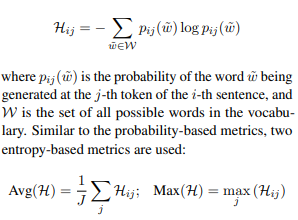

Ecrivez une fonction permettant de calculer la moyenne d'entropie d'une génération sur la base des top logprobs. Puis avec cette fonction, déterminez l'entropie des génération issu de: "Lionel messi is a", "Jean Dagobert is a " Que constatez vous? Essayez avec la phrase "Rihanna is a" que constatez vous ? Concluez sur les limites de cette méthode.

In [15]:
import numpy as np

def entropy(logprobs):
    """
    Calcule l'entropie d'une liste de log-probabilités.

    :param logprobs: Liste des log-probabilités pour un token.
    :return: Entropie du token.
    """
    # Convertir les log-probabilités en probabilités
    probs = np.exp(logprobs)
    # Normaliser les probabilités pour s'assurer qu'elles forment une distribution valide
    probs /= np.sum(probs)
    # Calculer l'entropie
    entropy = -np.sum(probs * np.log(probs))
    return entropy

def moyenne_entropie(llm_output):
    """
    Calcule l'entropie moyenne pour une génération de LLM basée sur les top logprobs.

    :param llm_output: Sortie du modèle de langage contenant les log-probabilités des tokens.
    :return: Entropie moyenne pour la génération.
    """
    total_entropy = 0
    num_tokens = len(llm_output['choices'][0]['logprobs']['top_logprobs'])

    for token_logprobs in llm_output['choices'][0]['logprobs']['top_logprobs']:
        total_entropy += entropy(list(token_logprobs.values()))

    return total_entropy / num_tokens
print(moyenne_entropie(results1))

0.5081072527915239


Bien que l'entropie soit un outil utile pour mesurer l'incertitude des LLMs, elle n'est pas sans limitations. En particulier, l'une de ses faiblesses majeures est qu'elle ne prend pas en compte la sémantique des mots. Cela peut conduire à des résultats trompeurs lors de l'évaluation de la certitude du modèle.

Par exemple, prenons les phrases "Paris est la capitale de la France" et "La capitale de la France est Paris". Ces deux phrases expriment la même information et sont toutes deux correctes d'un point de vue sémantique. Cependant, en raison de la façon dont l'entropie est calculée, elles peuvent avoir des valeurs d'entropie très différentes.

Cela se produit parce que l'entropie mesure l'incertitude du modèle en se basant uniquement sur la distribution de probabilité des tokens prédits, sans prendre en compte la signification de ces tokens. Ainsi, même si les deux phrases sont sémantiquement équivalentes, le modèle peut être plus sûr de lui lorsqu'il prédit l'une que l'autre, conduisant à des valeurs d'entropie différentes.

C'est pourquoi nous allons utiliser une méthode appelée SelfcheckGPT.



https://arxiv.org/abs/2303.08896

SelfCheckGPT est une méthode développée pour aider à identifier et réduire les hallucinations dans les réponses générées par les modèles de langage comme GPT. Les hallucinations se produisent lorsque le modèle génère des informations incorrectes ou non fondées, ce qui peut poser des problèmes dans des contextes où la précision est essentielle, tels que la recherche scientifique, les diagnostics médicaux, ou les décisions juridiques.
Principe de SelfCheckGPT
L'idée centrale de SelfCheckGPT est d'utiliser le modèle GPT lui-même pour vérifier ses propres réponses. Cette méthode repose sur plusieurs étapes clés :
1.	Génération Initiale :
Le modèle GPT génère une première réponse à une question ou un prompt donné.
2.	Répétition et Diversité :
Pour évaluer la fiabilité de cette réponse, le modèle génère plusieurs versions de la réponse à partir du même prompt. Cela est fait en utilisant des techniques de rééchantillonnage, telles que l'utilisation de différentes graines aléatoires ou de légères variations dans les prompts.
3.	Analyse de Consistance :
Les réponses multiples générées sont ensuite comparées entre elles. Si les réponses sont similaires ou cohérentes entre elles, cela augmente la confiance en la validité de l'information. Si les réponses varient considérablement, cela peut indiquer une possible hallucination. Notamment, dans ce tp nous utiliserons un modèle NLI pour mesurer cette cohérence.

Ici le modèle NLI permet de classes les paires (réponse, affirmation de référence) en trois catégories : Entailment (impliqué), Neutral (neutre), ou Contradiction (contradiction). Une probabilité est donnée pour appartenir à la dite catégorie.

Ainsi, dans la suite de notre travaille, nous allons réimplémenter la méthode et étudier ces performances.

In [6]:
from transformers import DebertaV2ForSequenceClassification, DebertaV2Tokenizer
import torch
import nltk

nli_model = "potsawee/deberta-v3-large-mnli"
tokenizer = DebertaV2Tokenizer.from_pretrained(nli_model)
model = DebertaV2ForSequenceClassification.from_pretrained(nli_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

nltk.download('punkt')

def gen(query):
    prompt = f"""
      You are an AI assistant. Given a question about it, create a short answer. If you don't know the answer, honestly say so.
      Question: {query}
      Answer:
    """
    output = llm.create_completion(prompt,
                max_tokens = 20,
                echo = False,
                temperature = 1,
                logprobs =100,
                )      # to return top 5 tokens

    return output

print(gen("Whos is Messi ?"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Llama.generate: prefix-match hit

llama_print_timings:        load time =    2950.22 ms
llama_print_timings:      sample time =      11.05 ms /    20 runs   (    0.55 ms per token,  1810.61 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   19063.09 ms /    20 runs   (  953.15 ms per token,     1.05 tokens per second)
llama_print_timings:       total time =   19090.84 ms /    20 tokens


{'id': 'cmpl-1dccd53c-e85d-44a2-9834-c0b8d06fa0f2', 'object': 'text_completion', 'created': 1717575914, 'model': 'mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'text': ' Lionel Messi is an Argentine professional soccer player who currently plays as a forward for Paris Saint', 'index': 0, 'logprobs': {'tokens': [' Lion', 'el', ' Mess', 'i', ' is', ' an', ' Argent', 'ine', ' professional', ' soccer', ' player', ' who', ' currently', ' plays', ' as', ' a', ' forward', ' for', ' Paris', ' Saint'], 'text_offset': [179, 184, 186, 191, 192, 195, 198, 205, 208, 221, 228, 235, 239, 249, 255, 258, 260, 268, 272, 278], 'token_logprobs': [-0.4169057, -1.19209275e-07, -0.0024738677, -4.7683704e-07, -7.867782e-06, -0.84684646, -0.00045730147, -0.0104964115, -0.00049864734, -2.8808954, -0.0090957815, -0.4837565, -0.09042948, -4.8755406e-05, -0.16231762, -2.8610189e-06, -0.00061576476, -0.0015592334, -0.056626014, -0.0002311201], 'top_logprobs': [{' Lion': -0.4169057, ' I': -1.1377861, ' Leo': -

Dans un premier temps, creer un fonction retournant une liste N génération avec le modele mistral avec une temperature de 1. Ces N génération constiturons notre échantillon de base.


In [10]:
from tqdm import tqdm
def sample(query,nb_sample):
  prompt = f"""
    You are an AI assistant. Given a question about it, create a short answer. If you don't know the answer, honestly say so.
    Question: {query}
    Answer:
  """
  liste = []
  for _ in tqdm(range(nb_sample)) :
    liste.append(gen(query)['choices'][0]['text'])

  return liste
print(sample("Whos is Messi ?", 3))

  0%|          | 0/3 [00:00<?, ?it/s]Llama.generate: prefix-match hit

llama_print_timings:        load time =    2950.22 ms
llama_print_timings:      sample time =      11.51 ms /    20 runs   (    0.58 ms per token,  1738.22 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   14536.81 ms /    20 runs   (  726.84 ms per token,     1.38 tokens per second)
llama_print_timings:       total time =   14569.76 ms /    20 tokens
 33%|███▎      | 1/3 [00:15<00:30, 15.20s/it]Llama.generate: prefix-match hit

llama_print_timings:        load time =    2950.22 ms
llama_print_timings:      sample time =      11.96 ms /    20 runs   (    0.60 ms per token,  1672.80 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     0 tokens (    -nan ms per token,     -nan tokens per second)
llama_print_timings:        eval time =   13554.36 ms /    20 runs  

[' Lionel Messi is a world-renowned Argentine professional footballer who currently plays as a', " I'm sorry for any confusion, but the question seems to be incomplete. 'Whos", ' Lionel Messi is an Argentine professional footballer who currently plays as a forward for Paris Saint']


Implémenter ensuite une fonction qui permet de séparer un string en une liste de phrase. Un conseil utiliser nltk 😉

In [12]:
!pip install nltk

# Exemple de string
texte = "Bonjour! Comment ça va? J'espère que vous allez bien. Passez une bonne journée."


def separate(passage=texte):
  import nltk
  nltk.download('punkt')

  from nltk.tokenize import sent_tokenize


  # Tokenisation des phrases
  phrases = sent_tokenize(passage)

  # Afficher la liste de phrases

  return phrases

print(separate())

['Bonjour!', 'Comment ça va?', "J'espère que vous allez bien \n Passez une bonne journée."]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Creer un fonction permettant d'implémenter cette formule:

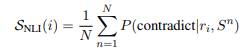

où Snli(i) correspond au score moyen de cohérence entre la i-ème phrase de la génération initiale et chaque échantillon. Sn correspond à la n-ème génération de l'échantillon et ri correspond à la i-ème phrase de la génération initiale. Enfin, P(contradict|ri,Sn) corrrespond à la probabilité que la phrase ri contredise la génération Sn. Cette probabilité est donnée par le model de classifications DeBerta importer juste au dessus.


In [13]:
def compute_score_phrase(sentence, samples):
  import numpy as np
  L = np.array([])
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification
  import torch.nn.functional as F

  # Charger le modèle et le tokenizer DeBERTa
  model_name = "microsoft/deberta-v3-large"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name)

  # Fonctions pour calculer la probabilité de contradiction
  def get_contradiction_probability(ri, Sn):
      inputs = tokenizer(ri, Sn, return_tensors="pt", truncation=True, padding=True)
      with torch.no_grad():
          outputs = model(**inputs)
      logits = outputs.logits
      probs = F.softmax(logits, dim=-1)
      contradiction_prob = probs[0][2].item()  # La classe "contradiction" est souvent la troisième classe (index 2)
      return contradiction_prob
  for sample in samples:
      L.append(get_contradiction_probability(sentence, sample))
  scores_per_sentence = np.sum(L)/len(L)
  return scores_per_sentence



Avec toute les fonctions définies précedemment implémenter une SelcheckNLI qui permet de calculer le score d'hallucination d'une génération. La fonction prendra en argumant la query de l'utilisateur, le passage genrer du llm et le nombre de sample. Tester la méthode avec des questions qui font halluciner le modèle et d'autres qui ne font pas halluciner le modèle. Voici le genre de question qui peuvent faire halluciner un modèle:

On choisira un nombre de sample égale à 5.
Concluez sur l'efficacité de la méthode SelfCheckNLI pour la détection d'hallucination. Quelles sont les limites de cette méthode ?

In [ ]:
def selfchecknli(query,generation,nb_sample):
  ###
  return###

Implémenter sur votre RAG une solution se basant sur SelcheckNLI pour pouvoir filtrer les hallucinations. Par exemple, lorsque une réponse à un score supérieur à un certains seuil le LLM devra avertir l'utilisateur qu'il n'est pas certains de sa réponse.


#Bonus:


1. Réalisez un dataset d'une vingtaine de questions comportant des questions qui font halluciner le LLM mistral et d'autres qui n'en font pas. Le dataset devra être équilibré
2. Générez des réponses pour chaque questions avec le LLM Mistral-7B et annotez chaque passage d'un 1 pour une hallucination, d'un 0 pour un passage factuel.
3. Pour chaque, passage attribuer un score d'hallucination avec SelfCheckNLI.
4. Afficher une matrice de confusion.
5. Tracer la courbe AUC PR. Concluez.
6. Determiner un seuil optimale pour detecter les hallucination par la méthode de votre choix.